## Skin Cancer Classification
Task is to build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:
- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

### Steps
#### - Data Reading/Data Understanding
#### - Dataset creation
#### - Dataset visualisation
#### - Model Building & training
#### - Data augmentation
#### - Model Building & training on the augmented data
#### - Class distribution
#### - Handling class imbalances
#### - Model Building & training on the rectified class imbalance data
#### - Conclusion

In [597]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

### Data Reading/Data Understanding

In [598]:
# from google.colab import drive
# drive.mount('/content/drive')

In [599]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("SkinImages/Train")
data_dir_test = pathlib.Path("SkinImages/Test")

In [600]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Dataset creation
##### Using batch size of 32 and resizing images to 180 x 180.

In [601]:
batch_size = 32
img_height = 180
img_width = 180

##### Using 80% of the images for training, and 20% for validation.

In [602]:
# Using seed=123 while creating training dataset using tf.keras.preprocessing.image_dataset_from_directory
# Resizing images to the size 180 x 180
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [603]:
# Using seed=123 while creating validation dataset using tf.keras.preprocessing.image_dataset_from_directory
# Resizing images to the size 180 x 180
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [604]:
# Storing List of all the classes of skin cancer from the class names in the class_names attribute on datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)
print("Number of classes: ", num_classes)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Number of classes:  9


### Dataset visualisation

In [605]:
# knowing image_batch and labels_batch size
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

##### visualize one instance of all the nine classes present in the dataset

Found 6739 files belonging to 9 classes.


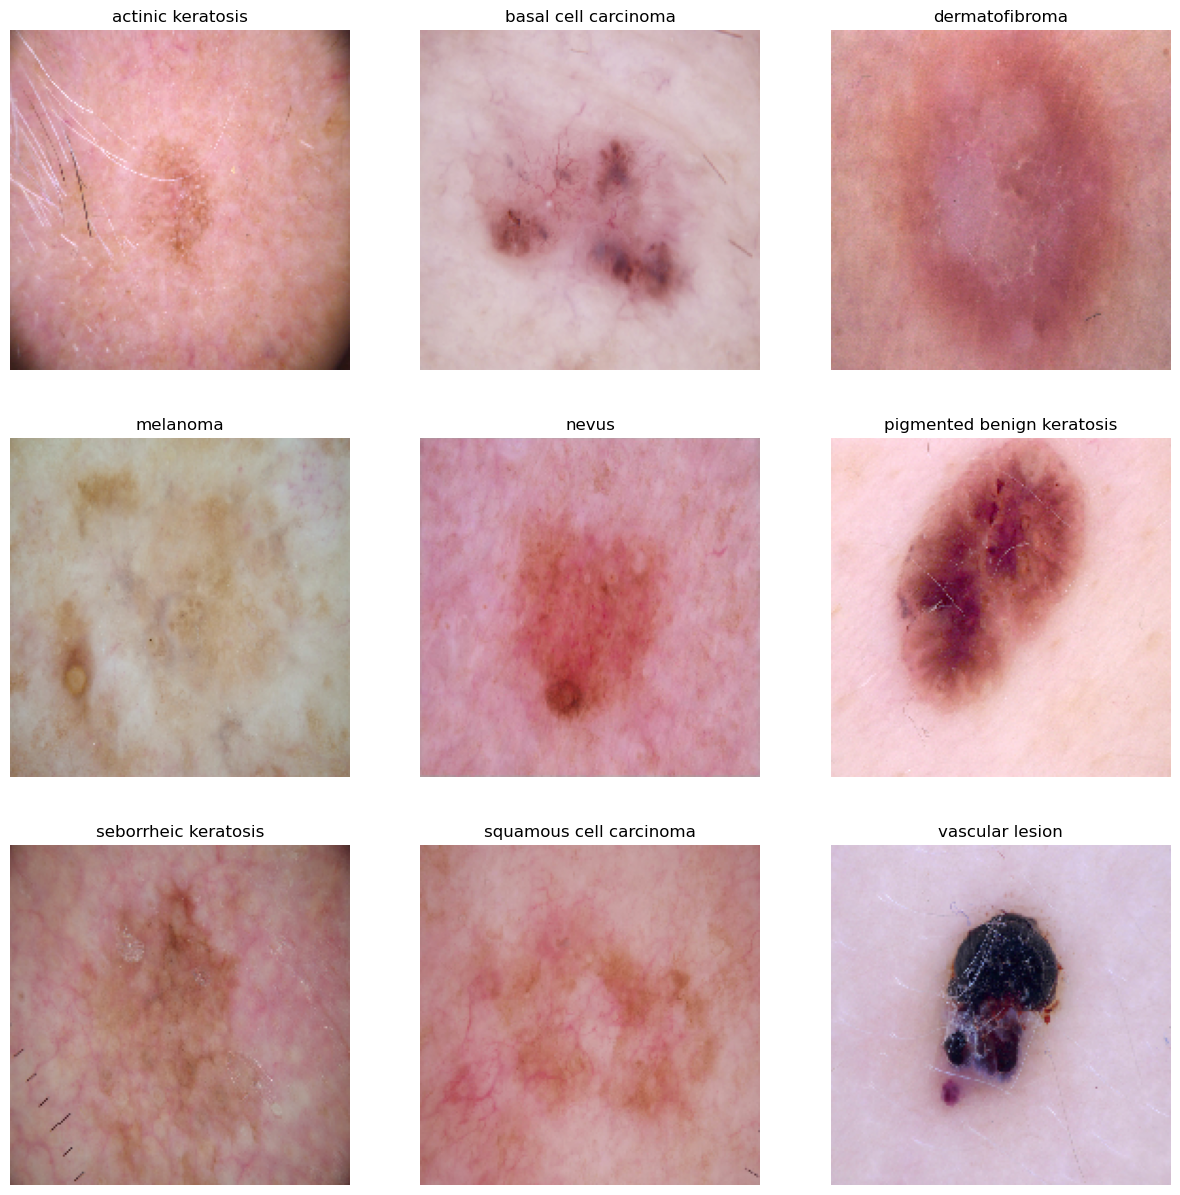

In [658]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")


### Model Building & training

##### Using `layers.Rescaling` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. It is good to standardize values to be in the `[0, 1]`

In [607]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [608]:
#model creation
model = Sequential([
    
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # Rescaling layer

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    #We slide over the feature map and extract tiles of a specified size.
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    #We slide over the feature map and extract tiles of a specified size.
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    #We slide over the feature map and extract tiles of a specified size.
    layers.MaxPooling2D(),
    #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting

    layers.Flatten(),
    #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector

    layers.Dense(128, activation='relu'),
    #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.

    layers.Dense(num_classes)# output dense layer
])

In [609]:
#using 'adam' optimizer
#Logits represent the raw scores or predictions produced by the model for each class, without any normalization.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [610]:
# View the summary of all layers
model.summary()

Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_72 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_222 (Conv2D)             │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_222               │ (None, 90, 90, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_223 (Conv2D)             │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_223               │ (None, 45, 45, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_224 (Conv2D)             │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_224               │ (None, 22, 22, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_78 (Flatten)            │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

##### Train the model

In [611]:
# training model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 27s 380ms/step - accuracy: 0.1708 - loss: 2.2682 - val_accuracy: 0.2864 - val_loss: 1.9185
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 342ms/step - accuracy: 0.3405 - loss: 1.7847 - val_accuracy: 0.5123 - val_loss: 1.4815
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 331ms/step - accuracy: 0.4774 - loss: 1.4901 - val_accuracy: 0.5257 - val_loss: 1.4499
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 383ms/step - accuracy: 0.5517 - loss: 1.3447 - val_accuracy: 0.5302 - val_loss: 1.4654
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 347ms/step - accuracy: 0.5676 - loss: 1.2064 - val_accuracy: 0.5168 - val_loss: 1.4968
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 334ms/step - accuracy: 0.5945 - loss: 1.1396 - val_accuracy: 0.5459 - val_loss: 1.5882
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 348ms/step - accuracy: 0.6102 - loss: 1.0943 - val_accuracy: 0.5459 - val_loss: 1.4538
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 331ms/step - accuracy: 0.6509 - loss: 0.9637 - val_accu

##### Visualizing the results

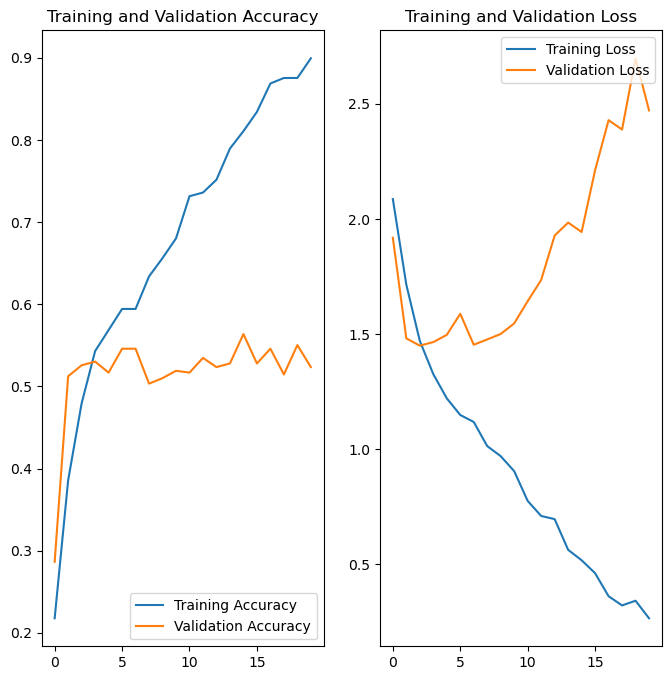

In [612]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### The model is performing well on train data but very poor on validation data. The plots show a large gap between train and validation accuracies so it is clear that model is overfitting.
##### We will use image augmentation to increase variability and see if we can improve the model performance.
##### We will also add dropout layers to prevent overfitting.

### Data augmentation


In [613]:
# Choosing the following strategy for data augmentation 
data_augmentation = keras.Sequential(
  [
#     layers.RandomFlip("horizontal",
#                       input_shape=(img_height,
#                                    img_width,
#                                    3)),
    layers.RandomRotation(0.1,
                      input_shape=(img_height,
                                   img_width,
                                   3)),
#     layers.RandomZoom(0.1),
#     layers.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
#     layers.RandomCrop(img_height,img_width),
  ]
)

##### visualizing how augmentation strategy works for one instance of training image.

2024-04-10 22:24:57.433008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


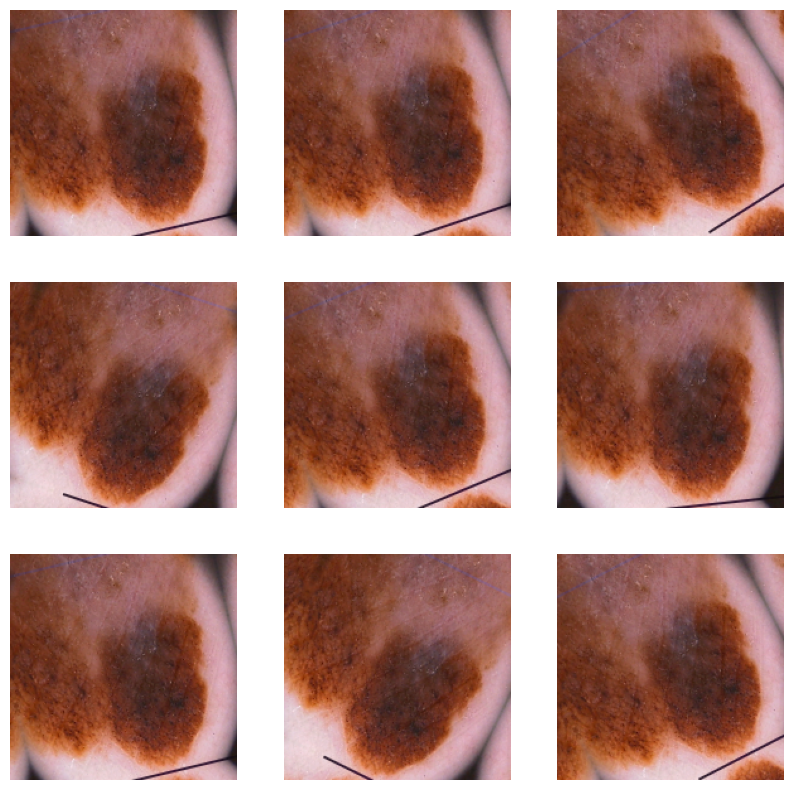

In [614]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Model Building & training on the augmented data

In [622]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [627]:
# Adding data_augmentation layer and adding 2 dropout layers for reducing overfitting 
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes)
])

In [628]:
#using 'adam' optimizer
#Logits represent the raw scores or predictions produced by the model for each class, without any normalization.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [629]:
model.summary()

Model: "sequential_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_84 (Sequential)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_75 (Rescaling)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_231 (Conv2D)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_231               │ ?                      │   0 (unbuilt) │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_232 (Conv2D)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_232               │ ?                      │   0 (unbuilt) │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_233 (Conv2D)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_233               │ ?                      │   0 (unbuilt) │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_81 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

##### Train the model

In [630]:
## training your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 401ms/step - accuracy: 0.1708 - loss: 2.1558 - val_accuracy: 0.1924 - val_loss: 2.0090
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.2149 - loss: 2.0499 - val_accuracy: 0.2640 - val_loss: 1.9103
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 361ms/step - accuracy: 0.2910 - loss: 1.9067 - val_accuracy: 0.3781 - val_loss: 1.6843
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 337ms/step - accuracy: 0.3702 - loss: 1.7636 - val_accuracy: 0.3647 - val_loss: 1.7110
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 336ms/step - accuracy: 0.4195 - loss: 1.6793 - val_accuracy: 0.4720 - val_loss: 1.5330
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 333ms/step - accuracy: 0.4295 - loss: 1.5808 - val_accuracy: 0.4564 - val_loss: 1.5244
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 342ms/step - accuracy: 0.4661 - loss: 1.5307 - val_accuracy: 0.5213 - val_loss: 1.3801
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 375ms/step - accuracy: 0.4887 - loss: 1.4731 - val_accu

##### Visualizing the results

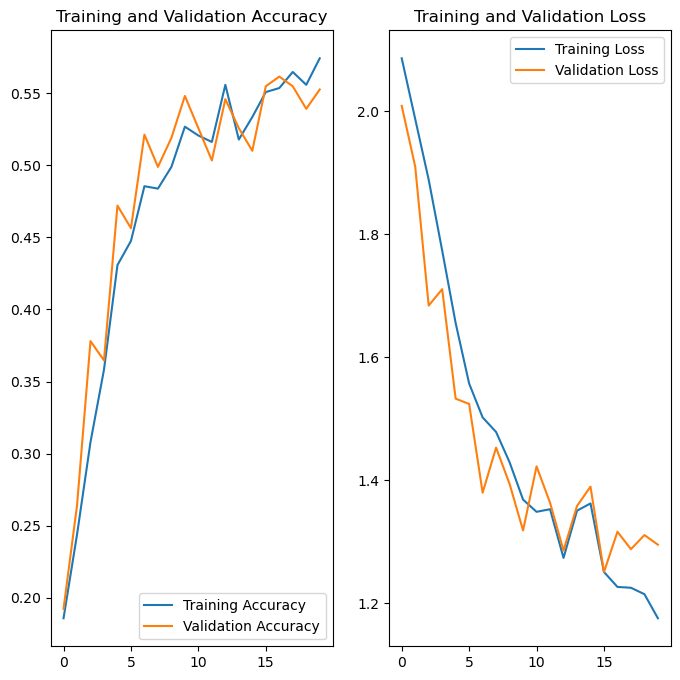

In [631]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### Though the gap between train and validation acuracies is now small both the train and validation accuracies are low indicating underfitting.
##### May be the model is unable to learn even basic patterns in data due to small train data.

##### Let us find out distribution of classes in the dataset to see if there is any class imbalance.

### Class distribution

##### Visualizing distribution of classes in the training dataset.

In [632]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,melanoma,438
1,pigmented benign keratosis,462
2,nevus,357
3,basal cell carcinoma,376
4,actinic keratosis,114
5,squamous cell carcinoma,181
6,vascular lesion,139
7,seborrheic keratosis,77
8,dermatofibroma,95


<Axes: xlabel='No. of Image', ylabel='Class'>

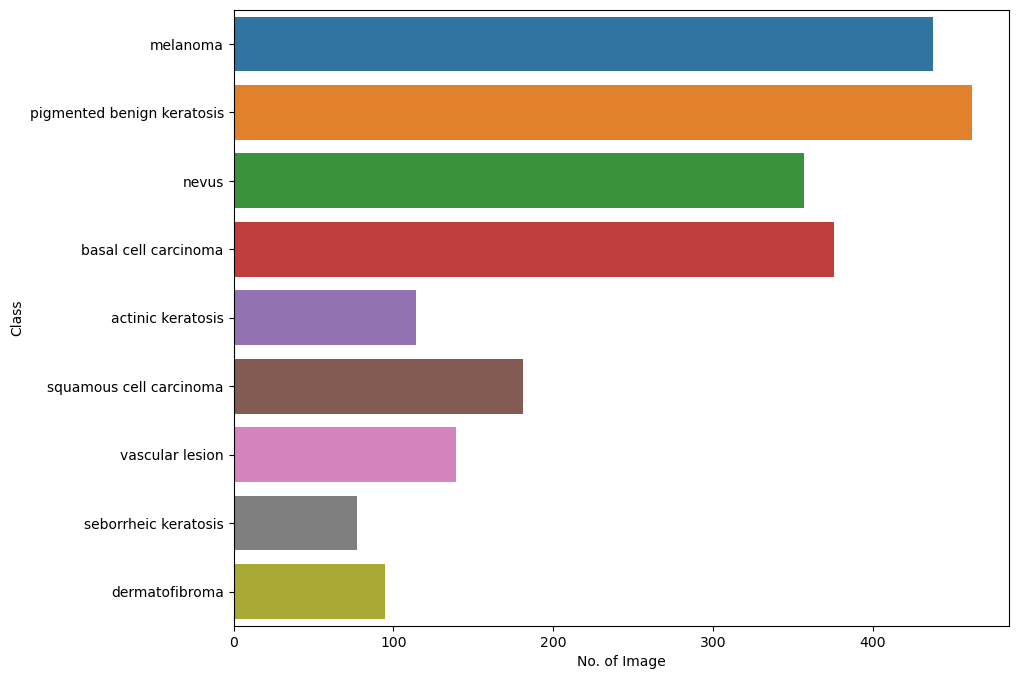

In [633]:
#Visualize the Number of images in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

##### `seborrheic keratosis` class has the least number of samples.
##### `pigmented benign keratosis`,`melanoma`,`basal cell carcinoma` and `nevus` classes dominate the data in terms of proportionate number of samples.

##### We can see there is a class imbalance. Some classes have very small number of train samples. To solve this we will use package `Augmentor` to add more samples across all classes so that none of the classes have very few samples.

### Handling class imbalances

In [634]:
#install Augmentor
!pip install Augmentor

In [635]:
path_to_training_dataset="SkinImages/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to SkinImages/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3


Initialised with 376 image(s) found.
Output directory set to SkinImages/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x377CDAA90>: 100%|█|


Initialised with 95 image(s) found.
Output directory set to SkinImages/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x377C25A50>: 100%|█|


Initialised with 438 image(s) found.
Output directory set to SkinImages/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x34F160BD0>: 100%|█


Initialised with 357 image(s) found.
Output directory set to SkinImages/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x386C65790>: 100%|█|


Initialised with 462 image(s) found.
Output directory set to SkinImages/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x377C4DD90>: 100%|█|


Initialised with 77 image(s) found.
Output directory set to SkinImages/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x386C58990>: 100%|█


Initialised with 181 image(s) found.
Output directory set to SkinImages/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x377C8A190>: 100%|█|


Initialised with 139 image(s) found.
Output directory set to SkinImages/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3


In [636]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Model Building & training on the rectified class imbalance data 

In [637]:
# creating train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [638]:
# creating validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [639]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [640]:
# removing data_augmentation layer and using remaining layers
model = Sequential([
    layers.Rescaling(1.0/255, input_shape=(img_height, img_width, 3)),  
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes)
])

/Users/daddy/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [641]:
#using 'adam' optimizer
#Logits represent the raw scores or predictions produced by the model for each class, without any normalization.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [642]:
model.summary()

Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_76 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_234 (Conv2D)             │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_234               │ (None, 90, 90, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_235 (Conv2D)             │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_235               │ (None, 45, 45, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_236 (Conv2D)             │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_236               │ (None, 22, 22, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_82 (Flatten)            │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

##### Training model

In [643]:
# using 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 77s 402ms/step - accuracy: 0.1711 - loss: 2.2665 - val_accuracy: 0.4024 - val_loss: 1.5856
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 60s 356ms/step - accuracy: 0.3864 - loss: 1.6531 - val_accuracy: 0.4588 - val_loss: 1.4752
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 58s 341ms/step - accuracy: 0.4132 - loss: 1.5129 - val_accuracy: 0.5115 - val_loss: 1.3008
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 58s 344ms/step - accuracy: 0.4751 - loss: 1.3880 - val_accuracy: 0.5316 - val_loss: 1.2740
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 60s 357ms/step - accuracy: 0.5163 - loss: 1.2844 - val_accuracy: 0.5650 - val_loss: 1.1691
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 62s 366ms/step - accuracy: 0.5763 - loss: 1.1544 - val_accuracy: 0.6169 - val_loss: 1.0624
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 58s 343ms/step - accuracy: 0.5851 - loss: 1.0987 - val_accuracy: 0.6526 - val_loss: 0.9944
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 56s 334ms/step - accuracy: 0.6131 - loss: 1

##### Visualising results

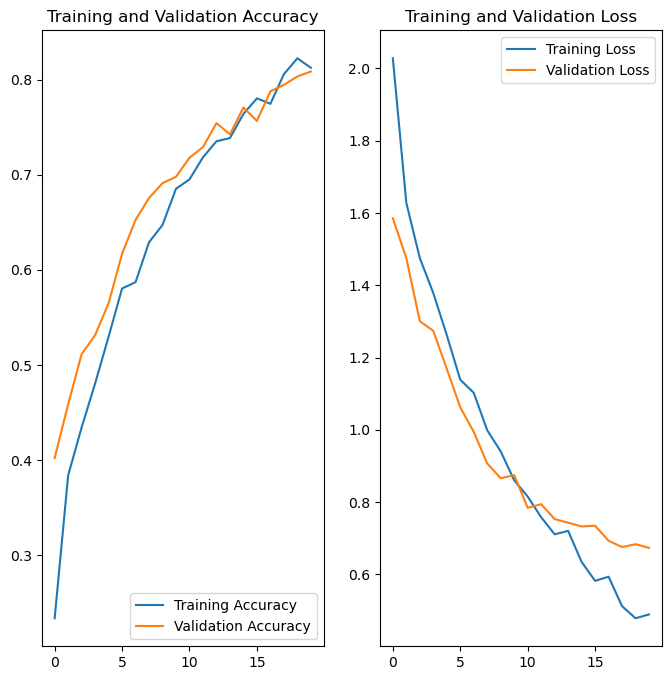

In [644]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss') 

plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Conclusion

##### By increasing number of image samples in each class (to rebalance the dataset) the model accuracies have now increased and we could get rid of underfitting also.
##### Data augmentation, class imbalance handling and adding dropout layers have greatly improved model performance.

##### Model Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


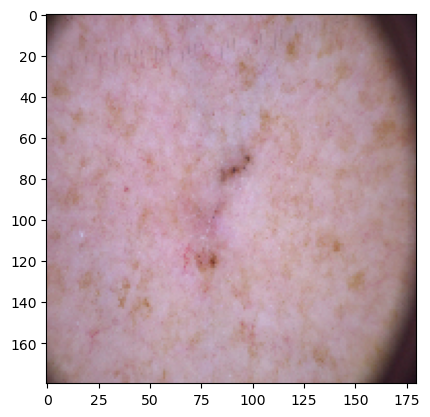

In [655]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-2],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )